# Imports

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
import networkx as nx
import seaborn as sns
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import random

# Information Agent

In [177]:
class InformationAgent(Agent):
    """ An agent with a grid. """
    def __init__(self, unique_id, model, initial_grid, error_rate):
        super().__init__(unique_id, model)
        self.grid_size = initial_grid.shape[0]
        self.error_rate = error_rate
        # Initialize grid with the provided initial grid and introduce errors
        self.grid = self._introduce_errors(initial_grid)

    def _introduce_errors(self, grid):
        """ Introduce random errors into the grid based on error_rate. """
        flat_grid = grid.flatten()
        random_numbers = np.random.rand(flat_grid.size)
        flat_grid[random_numbers < self.error_rate] = 1 - flat_grid[random_numbers < self.error_rate]
        return flat_grid.reshape(grid.shape)

### 1. Gossip Protocol

Each agent randomly communicates with neighbors.

In [179]:
class GossipAgent(InformationAgent):
    def step(self):
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        if len(neighbors) < 1:
            return
        
        # Randomly choose a neighbor to exchange grids with
        neighbor = self.random.choice(neighbors)
        # Randomly mix grids to simulate gossip
        self.grid = (self.grid + neighbor.grid) // 2

### 2. Reputation-Based Communication

Agents weigh the received grids based on the reputation or reliability of neighbors.

In [180]:
class ReputationAgent(InformationAgent):
    def __init__(self, unique_id, model, initial_grid, error_rate):
        super().__init__(unique_id, model, initial_grid, error_rate)
        self.reputation = {}  # Dictionary to store reputation scores for neighbors

    def step(self):
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        if len(neighbors) < 1:
            return
        
        # Update reputation based on past performance (implement a function to update reputation)
        # Here we use a simple average of neighbors' grids weighted by reputation
        total_weight = 0
        weighted_sum = np.zeros_like(self.grid)
        
        for neighbor in neighbors:
            weight = self.reputation.get(neighbor.unique_id, 1)  # Default weight is 1
            total_weight += weight
            weighted_sum += weight * neighbor.grid
        
        if total_weight > 0:
            self.grid = weighted_sum / total_weight


### 3. Event-Triggered Communication

Agents communicate only when significant discrepancies are detected.

In [181]:
class EventTriggeredAgent(InformationAgent):
    def __init__(self, unique_id, model, initial_grid, error_rate, threshold=0.1):
        super().__init__(unique_id, model, initial_grid, error_rate)
        self.threshold = threshold

    def step(self):
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        if len(neighbors) < 1:
            return
        
        # Check for discrepancies with neighbors
        for neighbor in neighbors:
            discrepancy = np.abs(self.grid - neighbor.grid).mean()
            if discrepancy > self.threshold:
                # Update grid based on neighbor's grid if discrepancy is significant
                self.grid = (self.grid + neighbor.grid) // 2


### 4. MajorityVotingAgent:


In [200]:
class MajorityVotingAgent(InformationAgent):
    
    def __init__(self, unique_id, model, initial_grid, error_rate, max_num_neigh=2):
        super().__init__(unique_id, model, initial_grid, error_rate)
        self.max_num_neigh = max_num_neigh
        
    def step(self):
        """Agent updates its grid using majority voting from its neighbors."""
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        if len(neighbors) < 2:
            return  # Not enough neighbors to proceed
        else: 
            pass
            neigh_to_consider = min (len(neighbors), self.max_num_neigh)
            neighbors = random.sample(neighbors, neigh_to_consider)

        # Extract grids from neighbors and self
        neighbor_grids = [self.grid] + [neighbor.grid for neighbor in neighbors]
        
        # Stack grids to compute the majority
        stacked_grids = np.stack(neighbor_grids, axis=-1)
        majority_grid = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=-1, arr=stacked_grids)
        
        # Update this agent's grid
        self.grid = majority_grid

# Information Dynamic 

In [218]:
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

class InformationSpreadModel(Model):
    """ Model to simulate the spread of information. """
    def __init__(self, N, grid_size, graph, error_rate, initial_grid, agent_type=InformationAgent, patience=10):
        self.num_agents = N
        self.grid = NetworkGrid(graph)
        self.grid_size = grid_size
        self.schedule = RandomActivation(self)
        self.original_grid = initial_grid
        self.avg_grids = []
        self.mse_list = []
        self.steps_taken = 0
        self.patience = patience
        self.no_improvement_counter = 0
        self.graph = graph

        # Create agents of the specified type
        for i in range(self.num_agents):
            a = agent_type(i, self, self.original_grid, error_rate)
            node = list(graph.nodes)[i % len(graph.nodes)]  # Place agent on nodes
            self.grid.place_agent(a, node)
            self.schedule.add(a)

    def step(self):
        if self.no_improvement_counter >= self.patience:
            self.running = False
            return

        previous_mse = self.mse_list[-1] if self.mse_list else float('inf')
        self.schedule.step()
        self._record_average_grid()
        mse = self.compute_distance()
        self.mse_list.append(mse)
        self.steps_taken += 1

        if mse >= previous_mse:
            self.no_improvement_counter += 1
        else:
            self.no_improvement_counter = 0

    def _record_average_grid(self):
        grids = [agent.grid for agent in self.schedule.agents]
        avg_grid = np.mean(grids, axis=0)
        self.avg_grid = avg_grid
        self.avg_grids.append(avg_grid)

    def compute_distance(self):
        mse = np.mean((self.original_grid - self.avg_grid) ** 2)
        return mse

    def plot_sim_results(self):
        """ Plot the average grids and the original grid. """
        num_steps = len(self.avg_grids)
        cols = 10
        rows = (num_steps + cols - 1) // cols
        plt.figure(figsize=(15, rows * 5))
        plt.subplot(rows, cols + 1, 1)
        plt.imshow(self.original_grid, cmap="binary")
        plt.title("Original Grid")
        for i, avg_grid in enumerate(self.avg_grids):
            plt.subplot(rows, cols + 1, i + 2)
            plt.imshow(avg_grid, cmap="binary")
            plt.title(f"Step {i + 1}")
        plt.subplots_adjust(left=0.05, right=0.95, top=0.4, bottom=0.05, wspace=0.2, hspace=0.2)
        plt.show()

    def plot_sim_last_results(self):
        """ Plot the original grid and the last average grid side by side, highlighting differences. """
        if not self.avg_grids:
            print("No average grids available to plot.")
            return
        
        # Calculate the differences between the original grid and the last average grid
        last_avg_grid = self.avg_grids[-1]
        difference = self.original_grid != np.round(last_avg_grid)
        
        plt.figure(figsize=(10, 5))
        
        # Plot the original grid
        plt.subplot(1, 2, 1)
        plt.imshow(self.original_grid, cmap="binary")
        plt.title("Original Grid")
        
        # Plot the last average grid
        plt.subplot(1, 2, 2)
        plt.imshow(last_avg_grid, cmap="binary")
        plt.title(f"Last Average Grid (Step {len(self.avg_grids)})")
        
        # Highlight the differences
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if difference[i, j]:
                    plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, edgecolor='red', facecolor='none', lw=2))
        
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.2)
        plt.show()

    def plot_sim_metrics(self):
        """ Plot MSE over time. """
        plt.figure(figsize=(12, 6))
        plt.plot(range(self.steps_taken), self.mse_list, label="MSE", color="red")
        plt.xlabel("Steps")
        plt.ylabel("Error")
        plt.title("Error Metrics over Time")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_network(self):
        """ Plot the network of agent connections. """
        pos = nx.spring_layout(self.graph)  # Layout for network visualization
        nx.draw(self.graph, pos, node_color='skyblue', node_size=100, edge_color='gray', font_size=16, font_weight='bold')
        plt.title('Agent Network')
        plt.show()

    def plot_consensus_convergence(self):
        """ Plot the percentage of correct grid cells over time to observe convergence. """
        correct_cells = [np.sum(np.round(avg_grid) == self.original_grid) for avg_grid in self.avg_grids]
        percentage_correct = np.array(correct_cells) / (self.grid_size * self.grid_size) * 100
        
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(percentage_correct)), percentage_correct, label="Percentage of Correct Cells", color="green")
        plt.xlabel("Steps")
        plt.ylabel("Percentage Correct")
        plt.title("Consensus Convergence Plot")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def plot_grid_variance(self):
        """Calculate and plot the variance of each grid cell across all agents as a heatmap, with values in each cell."""
        
        # Collect all grids from the agents
        grids = np.array([agent.grid for agent in self.schedule.agents])
        
        # Compute the variance for each cell across all agents
        grid_variance = np.var(grids, axis=0)
        
        # Plot the variance as a heatmap
        plt.figure(figsize=(8, 8))
        plt.imshow(grid_variance, cmap='viridis', interpolation='nearest', alpha=0.5)
        plt.colorbar(label="Variance")
        plt.title("Variance of Each Grid Cell Across All Agents")
        plt.xlabel("Grid X")
        plt.ylabel("Grid Y")
        
        # Add variance value as text in each cell
        for i in range(grid_variance.shape[0]):
            for j in range(grid_variance.shape[1]):
                plt.text(j, i, f"{grid_variance[i, j]:.2f}",
                         ha="center", va="center", color="black")
    
    plt.show()
        
    def run_simulation(self):
        """ Run the simulation until early stopping criteria are met. """
        
        while self.running:
            self.step()
            # Here you would add code to track communication edges if needed
            # communication_edges.append(...)
        
        self.plot_sim_last_results()
        self.plot_sim_metrics()
        self.plot_network()
        #self.plot_grid_error_heatmap()
        #self.plot_network_communication(communication_edges)
        #self.plot_consensus_convergence()


# Usage

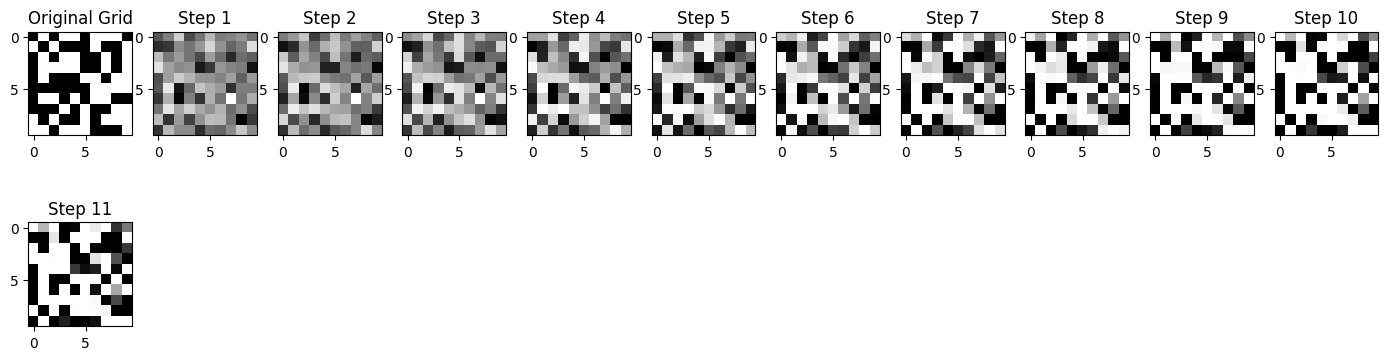

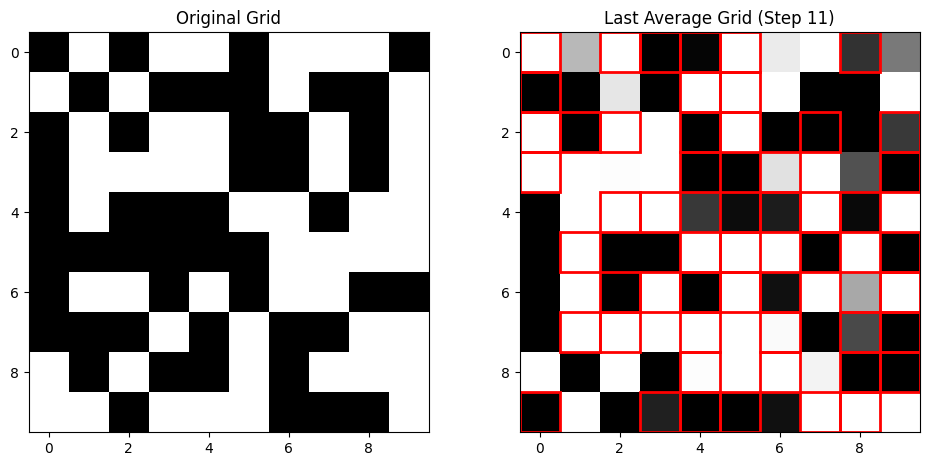

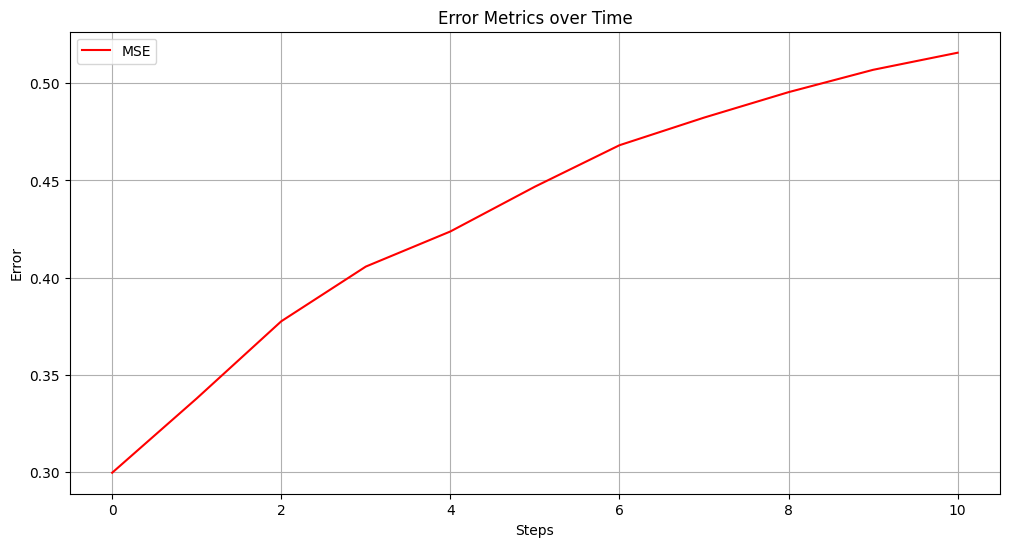

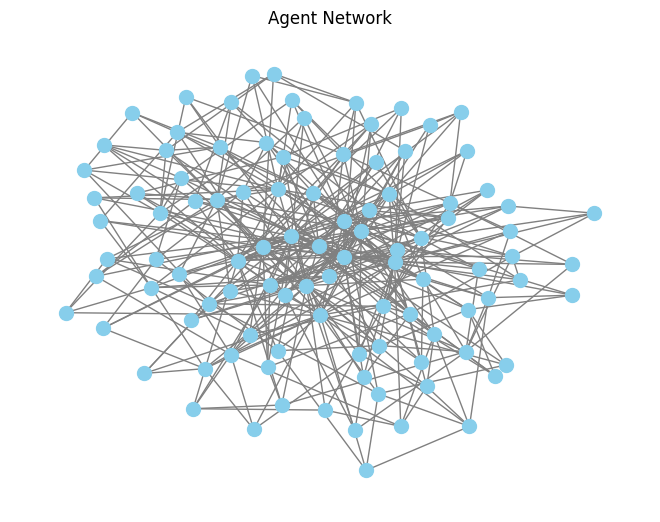

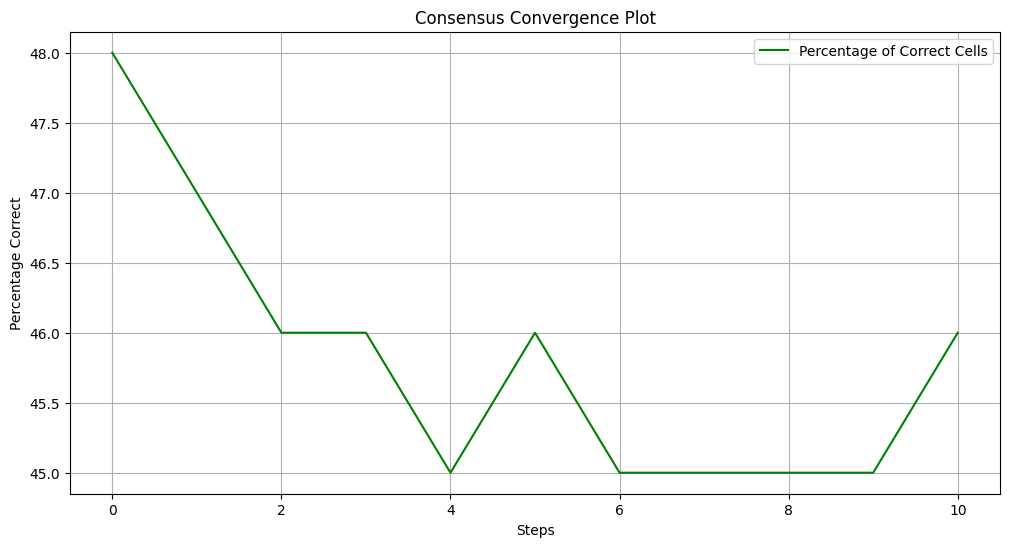

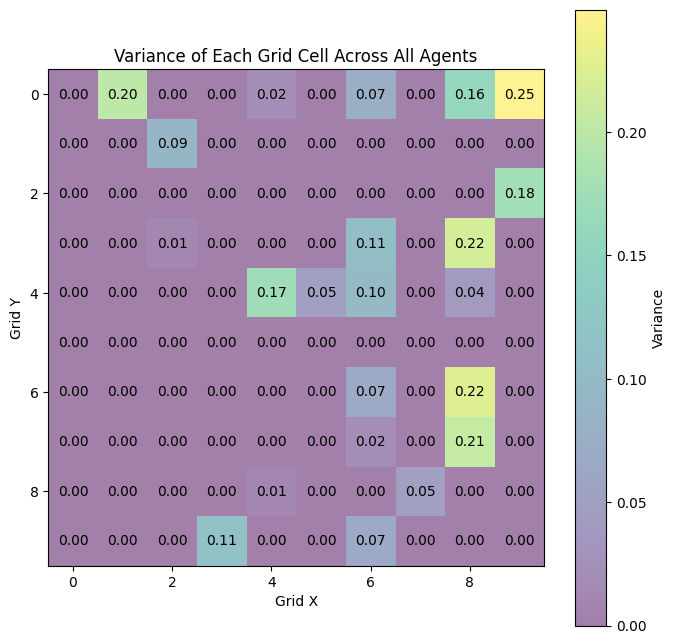

In [219]:
def run_simulation(agent_type=InformationAgent):
    
    grid_size = 10
    num_agents = 100
    error_rate = 0.5
    num_steps = 100

    initial_grid = np.random.randint(2, size=(grid_size, grid_size))
    
    G = nx.powerlaw_cluster_graph(num_agents, m=4, p=0.1, seed=42)
    #G = nx.erdos_renyi_graph(num_agents, p= 0.05, seed=42) 
    #G = nx.complete_graph(num_agents)
    
    model = InformationSpreadModel(num_agents, 
                                   grid_size, G, 
                                   error_rate, 
                                   initial_grid, 
                                   agent_type=agent_type,
                                   patience=10
                                  )
    
    for _ in range(num_steps):
        model.step()
    
    model.plot_sim_results()
    model.plot_sim_last_results()
    model.plot_sim_metrics()
    model.plot_network()
    model.plot_consensus_convergence()
    model.plot_grid_variance()

# Run simulation with different agent types
    
run_simulation(agent_type=MajorityVotingAgent) # Don't Forget to set max_num_neigh
# run_simulation(agent_type=GossipAgent)
# run_simulation(agent_type=ReputationAgent)
# run_simulation(agent_type=EventTriggeredAgent)